In [63]:
import numpy as np
import matplotlib.pyplot as plt

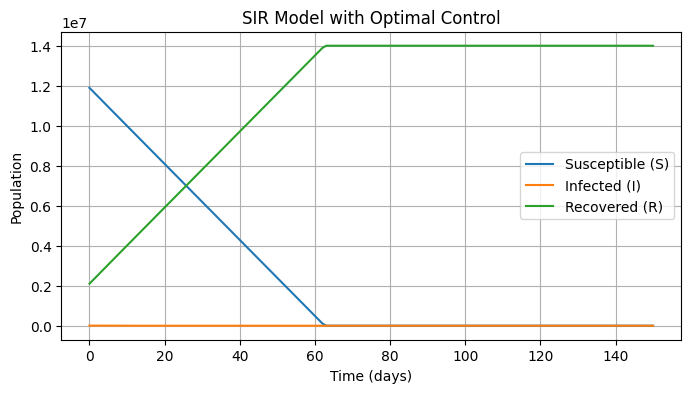

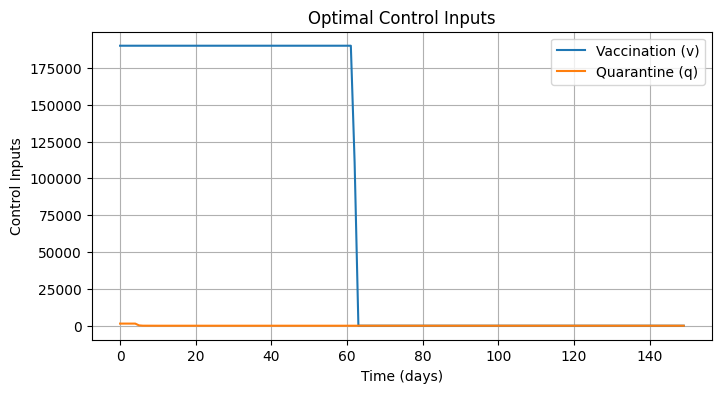

感染収束までの日数: 7 日
合計感染者数: 17869 人
最大感染者数: 5288 人


In [79]:
# パラメータ設定
T = 150  # 時間ステップ
dt = 1  # 時間刻み

N = 1.4 * 10**7    # 全人口
I0 = 5288            # 初期感染者数
R0 = N * 0.15             # 初期回復者数
S0 = N - I0 - R0   # 初期の感受性者数

gamma = 0.1        # 回復率
r0 = 2.28        # 基本再生産数
beta = r0 * gamma / S0  # 伝染率

V_max = 1.9 * 10**5  # 最大接種数から導出
Q_max = 1442  # 隔離最大量　開放されたホテルの部屋数から導出


# 重みパラメータ
mu_I = 1  # 感染者数のコスト
mu_v = 0.27 * 10/17  # ワクチンコスト
mu_q = 10/17  # 隔離コスト
mu_S = 0.001  # 感受性者数のコスト
mu_R = 0.001  # 回復者数のコスト


# 初期化
S = np.zeros(T + 1)
I = np.zeros(T + 1)
R = np.zeros(T + 1)
v = np.zeros(T)
q = np.zeros(T)

lambda_S = np.zeros(T + 1)
lambda_I = np.zeros(T + 1)
lambda_R = np.zeros(T + 1)

# 初期状態と終端条件
S[0], I[0], R[0] = S0, I0, R0

# 終端条件
# 集団免疫率の計算
H_c = 1 - (1 / r0)  # 集団免疫率

# 目標値の設定
S_goal = (1-H_c) * N  # 未感染者の目標 
R_goal = H_c * N  # 回復者の目標 
I_goal = 0        # 感染者は0にする

# 重みパラメータ
w_S = 0.001  # 未感染者の重み
w_I = 1 # 感染者の重み 
w_R = 0.001  # 回復者の重み


# 共役変数の終端条件
lambda_S[-1] = 2 * w_S * (S[-1] - S_goal) - mu_S
lambda_I[-1] = 2 * w_I * (I[-1] - I_goal) + 2 * mu_I * I[-1]
lambda_R[-1] = 2 * w_R * (R[-1] - R_goal) - mu_R

# 反復計算
epsilon = 1e-3  # 収束条件
max_iter = 100  # 最大反復回数
for iteration in range(max_iter):
    # 逆向きに共役変数を更新
    for t in reversed(range(T)):
        # 共役変数の更新
        lambda_S[t] = lambda_S[t + 1] - mu_S + beta * I[t] * (lambda_I[t + 1] - lambda_S[t + 1])
        lambda_I[t] = lambda_I[t + 1] + 2 * mu_I * I[t] + beta * S[t] * (lambda_I[t + 1] - lambda_S[t + 1]) + gamma * (lambda_R[t + 1] - lambda_I[t + 1])
        lambda_R[t] = lambda_R[t + 1] - mu_R
        

    # 順方向に状態を更新
    prev_v = v.copy()
    prev_q = q.copy()
    for t in range(T):
        # 最適制御入力の計算
        v[t] = np.clip((lambda_S[t + 1] - lambda_R[t + 1]) / (2 * mu_v), 0, min(S[t], V_max))
        q[t] = np.clip((lambda_I[t + 1] - lambda_R[t + 1]) / (2 * mu_q), 0, min(I[t], Q_max))
        
        
        # 状態遷移 (修正版)
        new_S = S[t] - beta * S[t] * I[t] - v[t]
        new_I = I[t] + beta * S[t] * I[t] - gamma * I[t] - q[t]
        new_R = R[t] + gamma * I[t] + v[t] + q[t]

        # 修正: 調整して総人口保存
        adjustment = N - (new_S + new_I + new_R)

        # 各変数に調整を分配
        S[t + 1] = max(0, new_S + adjustment * (S[t] / N))
        I[t + 1] = max(0, new_I + adjustment * (I[t] / N))
        R[t + 1] = max(0, new_R + adjustment * (R[t] / N))

    # 収束判定
    if np.max(np.abs(v - prev_v)) < epsilon and np.max(np.abs(q - prev_q)) < epsilon:
        break

# 結果のプロット
time = np.arange(T + 1)

plt.figure(figsize=(8, 4))
plt.plot(time, S, label='Susceptible (S)')
plt.plot(time, I, label='Infected (I)')
plt.plot(time, R, label='Recovered (R)')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SIR Model with Optimal Control')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(np.arange(T), v, label='Vaccination (v)')
plt.plot(np.arange(T), q, label='Quarantine (q)')
plt.xlabel('Time (days)')
plt.ylabel('Control Inputs')
plt.title('Optimal Control Inputs')
plt.legend()
plt.grid(True)
plt.show()

# 感染収束日数 (感染者が一定以下に減少する日を判断)
threshold = 10  # 感染者数の閾値 (例えば10人未満で収束と定義)
days_to_contain = np.argmax(I < threshold)  # 最初に閾値を下回った日
cumulative_infected = np.sum(I) * dt
max_infected = np.max(I)
print(f"感染収束までの日数: {days_to_contain} 日")
print(f"合計感染者数: {cumulative_infected:.0f} 人")
print(f"最大感染者数: {max_infected:.0f} 人")